## Exponentially Weighted Smoothing II
<br>  
**Objectives**  
- Implement Holt-Winters’ additive method manually
- Learn how to use `statsmodels` library to call Holt-Winters’ method

**quick review of lec06**


**quick review of tut06**  
1. exponential weighted function  
`alist[i]`  
`alist.append(new_element)`    
`series.ewm(alpha, adjust = False).mean()`   
`series.tolist()`  


2. find the optimal alpha    
`sse = np.sum(np.power(a,2))`  
`alphas[np.argmin(sse)]`    


3. trend-corrected exponential smoothing

In the previous tutorial, we learned how to use the simple exponential smoothing and trend corrected method (Holt's linear) to smooth a time series and to forecast the time series. However, although we could obtain a reasonable outcome for simple cases, we have not considered the influence of <span class="girk">seasonal variations</span>, which may cause inaccurate forecasting result in some complicated situations. 

In this tutorial, we will go one-step further, taking the seasonal variations into account in the forecasting/smoothing steps. By doing this, we will learn Holt-Winters smoothing algorithm. 

Generally, for Holt-Winter smoothing algorithm, you still need to refer to the smoothing equation in simple exponential smoothing to smooth each component. When doing forecasts, we rely on the forecast equation and three smoothing equations - one for the level $l$, one for the trend/slope $b$ and one for the seasonal component $S$, with corresponding smoothing parameters $\alpha$, $\beta$ and $\gamma$. 

Mathematically, for additive Holt-Winters' method, the forecast is calculated as:
$$\widehat{y_{t+h|1:t}} = l_t + hb_t + S_{t - M + (h \ mod \ M)}$$  
the level is:
$$l_t = \alpha(y_t - s_{t-M}) + (1 - \alpha)(l_{t-1} + b_{t-1})$$
the trend is:
$$b_t = \beta (l_t - l_{t-1}) + (1 - \beta)b_{t-1}$$
and the seasonal variation is:
$$s_t = \gamma(y_t - l_{t-1} - b_{t-1}) + (1 - \gamma)s_{t-M}$$

where $M$ is the period number, $k$ is the <span class="mark">integer part</span> $(h - 1)/m$, which ensures that the estimates of the seasonal indices used for forecasting come from the <span class="girk">final year of the sample</span>. $0 ≤ \alpha ≤ 1$, $0 ≤ \beta ≤ 1$ and $0 ≤ \gamma ≤ 1$ defines the weight decaying.

For one-step forecasting, we have $h = 1$, hence $k = \frac{h-1}{M} = \frac{0}{M} = 0$, so the forecast is 

$$\widehat{y_{t+1|1:t}} = l_t + 1 \times b_t + s_{t+1-M}$$

Holt-winters' additive (or multiplicative) method has three hyper-parameters (i.e. $\alpha$, $\beta$ and $\gamma$). Their values have influence on the forecast accuracy. Usually we shall select the <span class="mark">best fitting hyper-parameters</span> by minimizing the SSE/MSE. This results in a nonlinear optimization problem over $\alpha$, $\beta$ and $\gamma$:

$$SSE = \sum\limits_{t=1}^n(y_t - \hat{y_t})^2 = \sum\limits_{t=1}^n(y_t - l_{t-1} - b_{t-1} - s_{t-M})^2$$

Also we need to find the <span class="mark">best initial</span> level $l_0$, slope/trend $b_0$ and $M$ initial seasonal values $s_0, s_{-1}, ..., s_{-M+1}$. It is suggested to do a linear regression over the data $y_1, y_2, ..., y_T$ to find the best fitting initial level $l_0$, slope/trend $b_0$:
$$\hat{y_t} = l_0 + b_0t$$

Then calculate seasonal series as the residual, $\hat{s_t} = y_t - \hat{y_t}$, and then take the <span class="girk">seasonal averages</span> of $\hat{s_t}$ as $s_0, s_1, ..., s_{1-M}$.

For Holt-Winters multiplicative smoothing, please refer to the lecture handout and the guide book: https://otexts.com/fpp2/holt-winters.html

### 1. Holt-Winters smoothing for forecasting manually

Let's starting with manually implement the Holt-Winters additive smoothing in order to gain a better understand.

#### Step 1: Importing the libraries and dataset
Download the `“AustralianVisitors.csv”` file from the QBUS6840 Canvas site.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# %config InlineBackend.figure_format = 'retina'

In [10]:
# import dataset and setup dependent variable (y)
visitors = pd.read_csv('AustralianVisitors.csv')
y = visitors['No of Visitors'] # 312 values in total

#### Step 2: Define a new addSeasonal() function:
In order to apply a Holt-Winters additive smoothing to the given time-series data, we need to <span class="burk">obtain many existing information</span>. Below is a check list. Make sure you obtained all these information:

|Information	            |Parameters                                      	|
|-----------------------	|------------------------------------------------	|
| Time Series Data      	| observation y and time index t                 	|
| Period Number         	| M                                              	|
| Hyper-parameters      	| $\alpha$, $\beta$ and $\gamma$                 	|
| Initial Values        	| $l_0$, $b_0$, and $s = s_0, s_1, ..., s_{1-M}$ 	|
| Number of Forecasting 	| fc                                             	|

Calling this function, we hope to get the final <span class="burk">smoothing results $y$, the level $l$, slope $b$, the seasonal variations $s$ and performance evaluation</span> (such as SSE,RMSE, etc…) as the returning values.

Read the code below and pay attention to the comments to understand the logic.

> **define: additive Holt Winter method**
>     - input:  x, M, fc; 
>               alpha, beta, gamma;
>               l0, b0, s
>     - output: forecasting result; 
>               l, b, s;
>               rmse
>     
> **calculation steps:**
>     1. create temp variables to calculate and store results: Y, l, b, s
>     2. check the initialization: 
>         - hyper-parameters: alpha, beta, gamma
>         - l0, b0, s
>     3. use for-loop to calculate the forecasting results (similar as tutorial 6)
>     4. compare the result with the true value and get RMSE

In [11]:
from math import sqrt

# additive Holt Winters
def addSeasonal(x, m, fc, 
                alpha = None, beta = None, gamma = None, 
                l0 = None, b0 = None, s = None):
    # initial some temp variables
    Y = x[:] # store the time series data in a new variable Y
    l = [] # create a new list for level values (l)
    b = [] # create a new list for trend values (b)
    s = [] # create a new list for seasonal values (s)
    
    # check the initialization
    # hyper-parameters
    if (alpha == None or beta == None or gamma == None):
        alpha, beta, gamma = 0.1, 0.1, 0.1 # set the default values of alpha, beta and gamma as 0.1
        # 1. alpha = None or beta = None or gamma = None: 0.1, 0.1, 0.1
        # 2. alpha = 0.1 or beta = 0.2 or gamma = 0.3: 0.1, 0.2, 0.3
        # 2. alpha = 0.1 or beta = 0.2 or gamma = None: 0.1, 0.1, 0.1
        
    # l_0, b_0 and s
    if (l0 == None or b0 == None or s == None): 
        l0,b0,s = linearOptimization(Y, m) 
        # use the slope and intercept of the linear regression as the initial value of l0 and b0
        # and use the average result of seasonal indices as s
        l.append(l0) # append l0
        b.append(b0) # append b0
    else: # if l0, b0 and s are specified
        l = l0
        b = b0
        s = s

    forecasted = [] # create a new list to store the forecasting result
    rmse = 0 # create a variable to store the model performance (evaluated by RMSE)
    
    # forecast from T = 1:t+fc
    for i in range(len(x) + fc):
        # when we reach the end of the original data
        # then we need to forecast the t = T:T+12
        if i == len(Y): # when t > T
            Y.append(l[-1] + b[-1] + s[-m+1]) # use the lastly updated values to make prediction
        # update the l,b,s and y
        # lt = alpha * (yt - St-m) + (1-alpha) * (lt-1 + bt-1)
        l.append(alpha * (Y[i] - s[i-m]) + (1 - alpha) * (l[i] + b[i])) 
        # bt = beta * (lt - lt-1) + (1-beta) * bt-1   
        b.append(beta * (l[i + 1] - l[i]) + (1 - beta) * b[i])
        # St = gamma * (yt - lt-1 - bt-1) + (1-gamma) * St-m  
        s.append(gamma * (Y[i] - l[i] - b[i]) + (1 - gamma) * s[i-m]) 
        # for forecasting, Yt+1 = lt +bt + st+1-m
        forecasted.append(l[i+1] + b[i+1] + s[i+1-m])
         
    # we can calculate in-sample rmse in the same way as we did in tutorial 6
    y_true = np.asarray(x[1:]).reshape(-1,1)
    y_forecast = np.asarray(forecasted[:-fc-1])
    rmse = sqrt(np.mean(np.power(y_true - y_forecast,2)))
    
    return forecasted, Y[-fc:], l, b, s, rmse

You may notice that we haven't define the `linearOptimization()` yet. Don't worry, we will come to this in the next step.

Firstly, let’s understand the logic in this function. Below are some tips:
1. You may notice some input are set to `None`, i.e. `alpha = None`. By default, the function requires `x`, `m`, `fc`, `alpha`, `beta`, `gamma`, `l0`, `b0`, and `s`, which is 9 variables as input. If you do not define/input the value of `alpha`, `beta`, `gamma`, `l0`, `b0`, `s`, this `addSeasonal()` function will set them as `None`.

2. In the beginning, we create some empty list variable, such as `l`, `s`, and `b`. These variables are used as containers for saving the calculation results.

3. If we don't define the value of `alpha`, `beta`, `gamma`, we will set them equal to 0.1. **However, it is still suggested to build a regression model to find the best fitting values based on the observations**.

4. If we don't define the `l0`, `b0`, and `s`, we will call the `linearOptimization()` to find the best fitting settings. Otherwise, we directly assign the predefined value to `l`, `b`, and `s`.

5. For each time index <span class="girk">t = 1:T+fc</span>, we calculate the `l`, `b`, and `s`. When t = T, this means we reach the end of the last observations. Therefore, we need to forecast $\widehat{y_T}: \widehat{y_{T+12}}$. You can find the corresponding condition and actions in the if condition: `if i == len(Y)`

#### Step 3: Fit the $l_0$, $b_0$ and $s_0, …,  𝑠_{1-M}$ by training a linear regression:

Continue with the previous step, we need to define a `linearOptimization()` function to find the best fitting $l_0$, $b_0$ and $s_0, …,  𝑠_{1-M}$. 

Here, we build a regression model to find the best fitting `l_0 = coef[0]` and `b_0 = intercept`.

Read the following code carefully and pay attention to the comments:

In [16]:
# optimize the best fitting l0, bo, and s
from sklearn.linear_model import LinearRegression

def linearOptimization(X, m):
    # define x = [1, 2, ..., t-1, t]
    x = np.linspace(1, len(X), len(X))
    x = np.reshape(x, (len(x), 1))
    y = np.reshape(X, (len(X), 1))
    # train a linear regression to get l_0 (intercept_) and b_0 (coef_[0])
    lm = LinearRegression().fit(x, y)
    l0 = lm.intercept_
    b0 = lm.coef_[0]
    
    # y_hat = level + trend
    # ts = level + trend + seasonal 
    # ts - y_hat = seasonal
    # avg(ts - y_hat)
    
    # use trained linear regression model to get y^t
    # then s^ = y-y^
    # finally average s^ to get s
    # The following statement is equal to:
    # s = np.mean(np.reshape(y + 0. - lm.predict(x),(int(len(X)/m),m)), axis=0)
    res = y - lm.predict(x) + 0. # seasonal = residual = y - y_hat
    res = np.reshape(res,(m,int(len(X)/m))) 
    s = np.mean(res,axis = 1) # take the mean value by row 
    # we have 12 months, so we should have 12 s values

    # check the datatype of l0, b, and s
    return l0[0], b0, s.tolist()

In [ ]:
     1     2     3
Jan  e1    e13    e25   avg_j
Feb  e2    e14    e26   avg_f
Mar  e3    e15    e27
... ........
Dec

s = [1, 2, .., 12]

What is the data type of $l_0$, $b_0$, and $s$?

In [57]:
l0.dtype

dtype('float64')

In [58]:
b0.dtype

dtype('float64')

In [61]:
s.dtype # notice that we return s as a list in the function

dtype('float64')

#### Step 4: Plot your smoothing results:
Finally, we call `matplotlib` library to plot the smoothing results and the corresponding level, slope/trend and seasonal.

Remember to call the `addSeasonal()` function to get the forecasting results.

In [17]:
fc = 12 # One year forecasting
M = 12 # Seasonal number

# check out the y datatype here
s_smoothed, Ys, l, b, s, rmse = addSeasonal(x = y.tolist(), m = M, fc = fc)

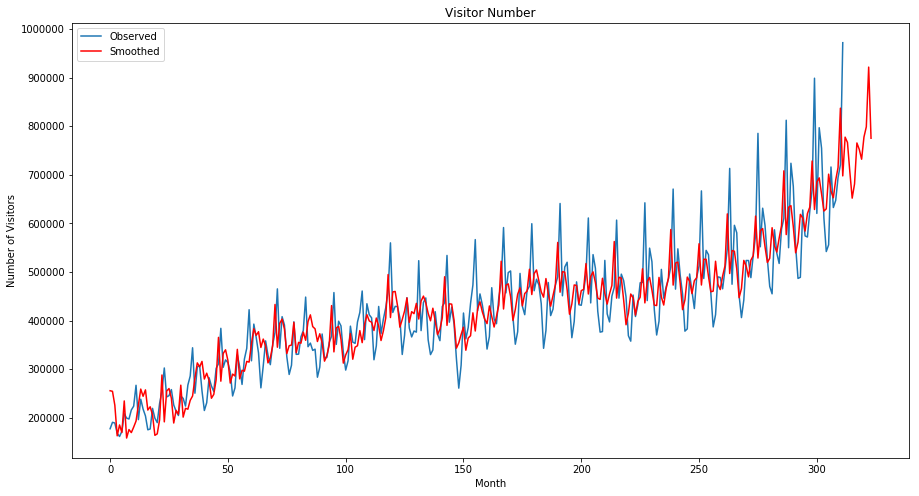

In [18]:
plt.figure(figsize = (15,8))
plt.plot(y, label = 'Observed')
plt.plot(s_smoothed[:], '-r', label = 'Smoothed')
plt.title('Visitor Number')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.legend(loc = 2);

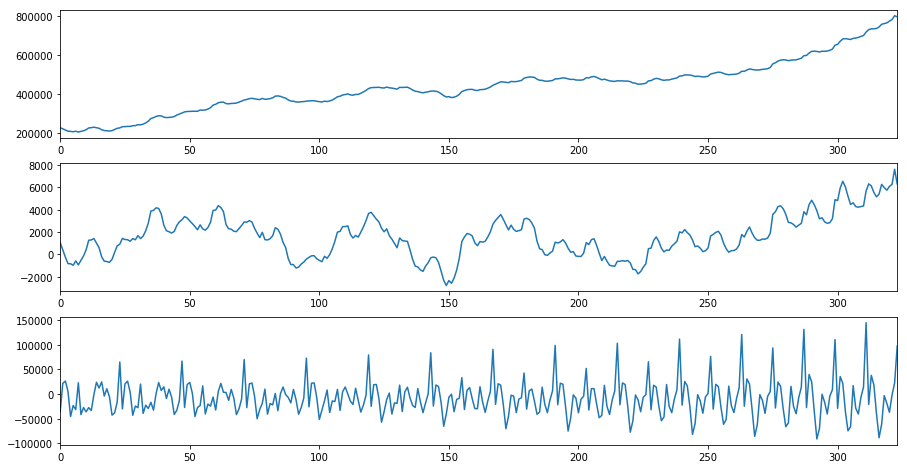

In [19]:
# remove l0,b0,s1~s12
states = pd.DataFrame(np.c_[l[1:], b[1:], s[12:]], columns=['level','slope','seasonal'])

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize = (15,8))
states['level'].plot(ax = ax1)
states['slope'].plot(ax = ax2)
states['seasonal'].plot(ax = ax3)
plt.show()

What is the size of $l$, $b$ and $s$ in the above code?

In [63]:
print('size of l = {}'.format(np.shape(states['level'])))
print('size of b = {}'.format(np.shape(states['slope'])))
print('size of s = {}'.format(np.shape(states['seasonal'])))

size of l = (324,)
size of b = (324,)
size of s = (324,)


From the first figure, we can observe that the smoothed curve does not fit the observation very closely. Can you suggest some ways in order to obtain a more accurate result?

**Hint**: think about the hyper parameters `alpha`, `beta`, `gamma`.

In [ ]:
# try step 4 of tutorial 6, but with alpha, beta and gamma
# 'grid-search'

In [ ]:
alpha, beta
10*10*10 = 100
a1 

(a1, b1)  
(a1, b2)  
(a1, b3)  
(a1, b4)  
(, ...)
(a1, b10)

(a2, b1)  
(a2, b2)  
(a2, b3)  
(a2, b4)  
(, ...)
(a2, b10)

a3  
a4  
... 
a10 

a10, b1  
a10, b2  
a10, b3  
a10, b4  
a10, ... 
a10, b10 

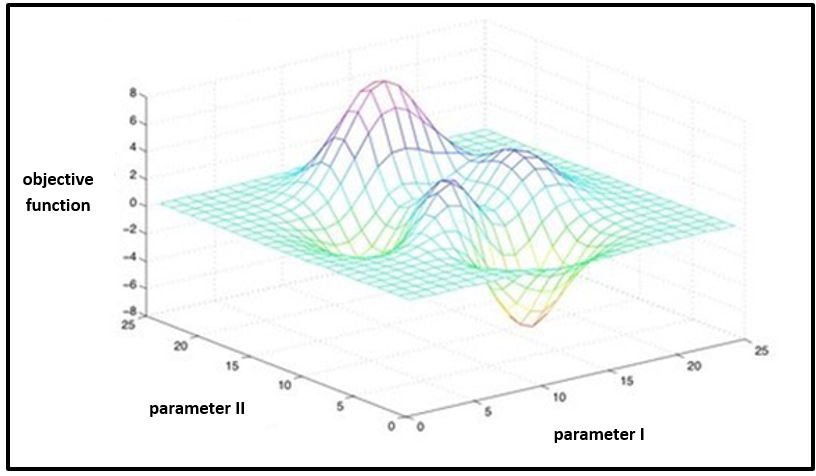

### 2. Holt-Winters smoothing in `statsmodels`

In this task we will use the build-in functions in `statsmodels` to smooth the data with Holt-Winters's method. This implementation is much better than our manual implementation in task 1 where we did not look for the best hyperparameters `alpha`, `beta`, `gamma`.

#### Step 1: Importing the libraries and dataset:
From the `statsmodels.tsa.holtwinters` library import the `ExponentialSmoothing` function:

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Step 2: Call the `ExponentialSmoothing` function to smooth the data:

Holt-Winter smoothing method has two smoothing methods for seasonal variations: additive and multiplicative. For some simple cases, you can choose the suitable method by eye-looking. However, it is still suggested to do both of the decomposition and select the one with smaller residual for the forecasting.

Therefore, in this step we call the `ExponentialSmoothing()` function twice to smooth the time-series data with defining the additive and multiplicative seasonal variations decomposition respectively.

In [11]:
# additive
fit1 = ExponentialSmoothing(y, seasonal_periods = 12, trend = 'add', seasonal = 'add').fit()

# multiplicative
fit2 = ExponentialSmoothing(y, seasonal_periods = 12, trend = 'add', seasonal = 'mul').fit()

Note that the `fit1` and `fit2` are object type variables. You may not be able to see the values of these variables in the Variable Explorer. If you want to know the fitting/smoothing results, you can print `.params[]` attributes, i.e. call `fit1.params['smoothing_level']` to get the best fitting 𝛼 value.

Similarly, you can get the besting fitting 𝛽, 𝛾, 𝜌, $𝑙_0$, and $b_0$ by calling different parameter settings. Below is an example:

In [64]:
# symbol r $ and \ in the results variable are the latex symbols for visualization in notebook
results = pd.DataFrame(index=[r"$\alpha$", 
                              r"$\beta$", 
                              r"$\phi$",  # damped value
                              r"$\gamma$", 
                              r"$l_0$", 
                              "$b_0$", 
                              "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', 
          'smoothing_slope', 
          'damping_slope', 
          'smoothing_seasonal', 
          'initial_level', 
          'initial_slope']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]

Execute the above code and check the outcome carefully:
1. What is the size of results variable?
2. What is the SSE outcome for both decomposition? Based on this, which decomposition we should choose?

In [85]:
# question (1)
np.shape(results)

(7, 2)

In [90]:
# question (2)
print('SSE of additive method       = {:.2f}'.format(fit1.sse))
print('SSE of multiplicative method = {:.2f}'.format(fit2.sse))

SSE of additive method       = 139990921192.54
SSE of multiplicative method = 112295461019.47


For more information of holtwinter function in statsmodels library, you can refer to the following two links:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.HoltWintersResults.html
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

#### Step 3: Plot the smoothing results:
After finding the best fitting parameters, we then need to plot the smoothing results. Here, you can call `.fitvalues` statement to check the smoothing results.

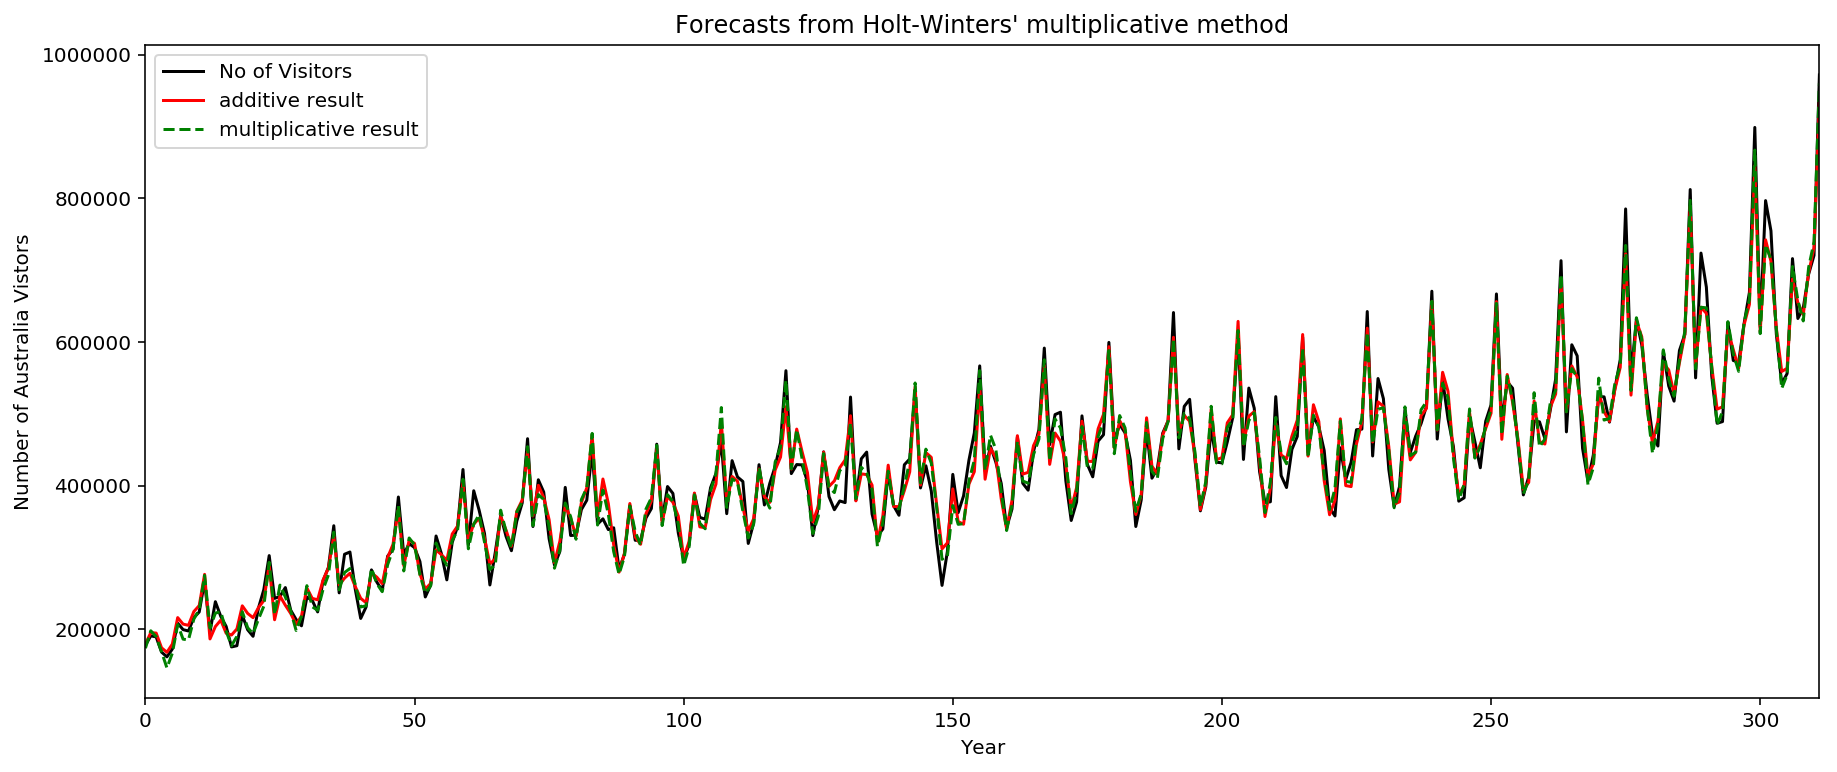

In [84]:
plt.figure()
ax = y.plot(figsize = (15,6), color = 'black', title = "Forecasts from Holt-Winters' multiplicative method")
ax.set_ylabel("Number of Australia Vistors")
ax.set_xlabel("Year")
            
# transfer the datatype to values
smooth_add = fit1.fittedvalues
smooth_mul = fit2.fittedvalues
smooth_add.plot(ax = ax, style = '-', color = 'red', label = 'additive result')
smooth_mul.plot(ax = ax, style = '--', color = 'green', label = 'multiplicative result')

ax.legend(fontsize = 10);

Can you also plot the level, slope, and seasonal?

Please check the `HoltWintersResults` class attributes by clicking the hyperlink in step 2!

#### Step 4: Forecast the future data:
Finally, based on the existing observations and best fitting parameters, let's forecast one more year. Here, you can call `.forecast()` function to forecast the T = t+1:t+N ,where N=12 in this case.

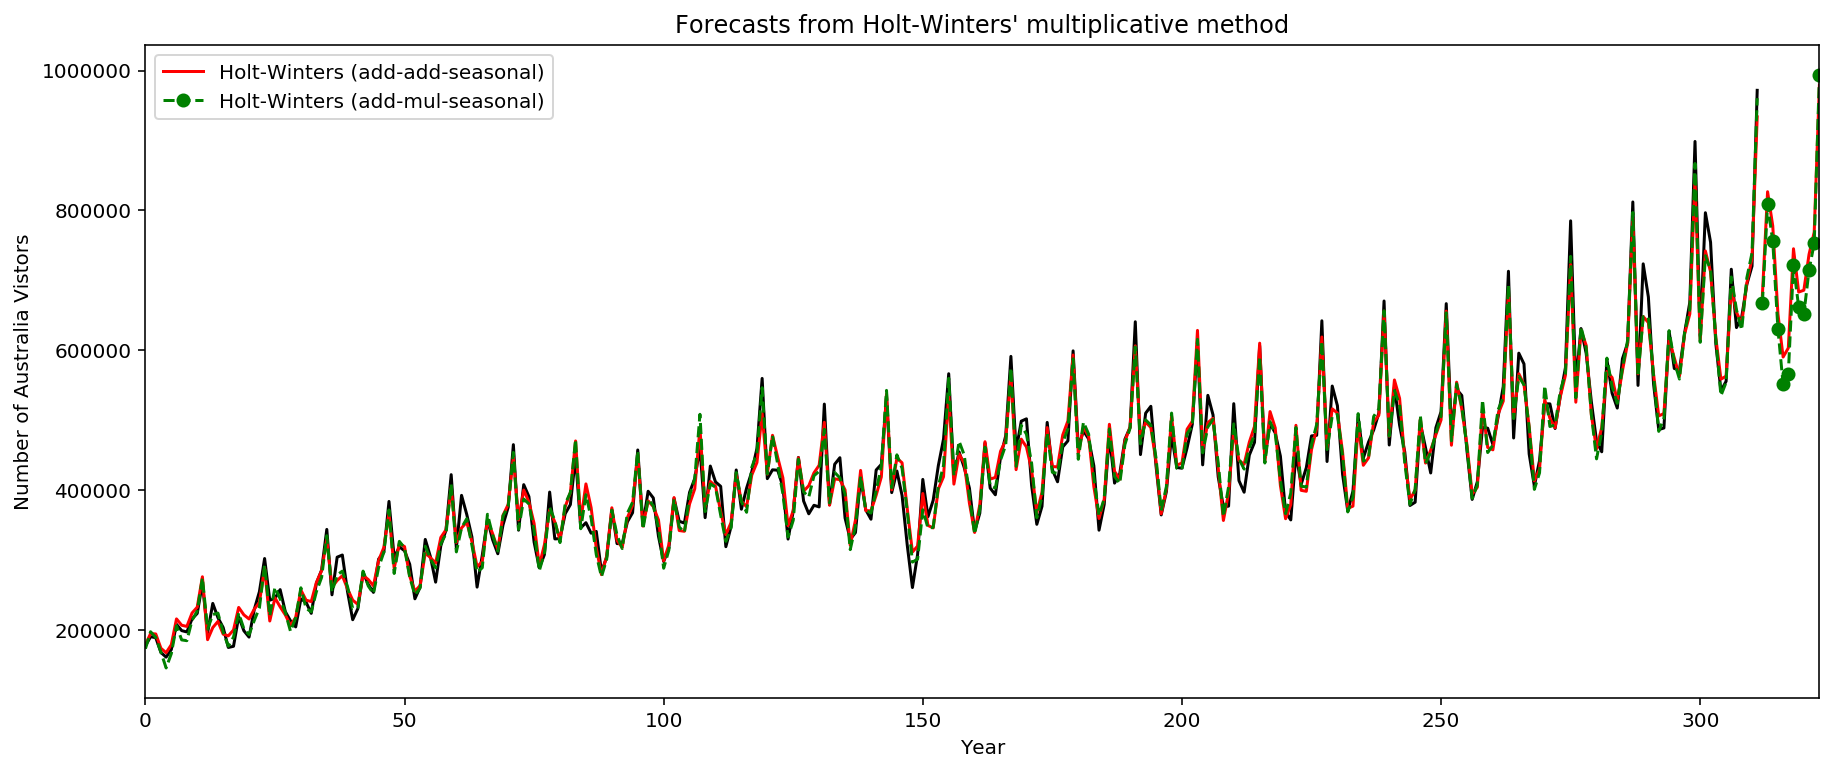

In [42]:
plt.figure()
ax = y.plot(figsize = (15,6), color = 'black', 
            title = "Forecasts from Holt-Winters' multiplicative method")
ax.set_ylabel("Number of Australia Vistors")
ax.set_xlabel("Year")
            
# transfer the datatype to values
smooth_add = fit1.fittedvalues
smooth_mul = fit2.fittedvalues
smooth_add.plot(ax = ax, style = '-', color = 'red')
smooth_mul.plot(ax = ax, style = '--', color = 'green')

forecast1 = fit1.forecast(12).rename('Holt-Winters (add-add-seasonal)')
forecast1.plot(ax = ax, style = '-', color = 'red', legend = True)
fit2.forecast(12).rename('Holt-Winters (add-mul-seasonal)').plot(ax = ax, style = '--', marker = 'o', 
                                                                 color = 'green', legend = True)

plt.show()

In [73]:
print("Forecasting Australia visitors using Holt-Winters method with both additive and multiplicative seasonality.")

results.round(4)


Forecasting Australia visitors using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Multiplicative
$\alpha$,2.5490e-01,4.1620e-01
$\beta$,2.1100e-02,6.2000e-03
$\phi$,NaN,NaN
$\gamma$,4.3080e-01,1.9460e-01
$l_0$,3.9614e+05,3.9778e+05
$b_0$,2.5806e+03,1.6153e+03
SSE,1.3999e+11,1.1230e+11


What is the data type and size of variable `forecast1`?

In [95]:
# data type
print('data type: {}'.format(forecast1.dtype))

# size
print('size of variable: {}'.format(np.shape(forecast1)))

data type: float64
size of variable: (12,)


#### Step 5: Further comparison of additive vs multiplicative:
In many situations, we can use SSE or MSE for the quantitative performance analysis. However, sometimes we still need to plot the further information such as level, slope/trend and seasonal component for the qualitative analysis. In this step, we aim to extract the smoothing results and plot them in one window for comparison.

Extract the smoothing information and use DataFrame variable to save these them.

In [35]:
# compare the forecasting outcomes of additive and multiplicative
# np.c_: Translates slice objects to concatenation along the second axis.

# additive
df1 = pd.DataFrame(np.c_[y, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues], 
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=y.index)

df1.append(fit1.forecast(24).rename(r'$\hat{y}_t$').to_frame()) # add 24 forecasting values at the end

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
0,1.792566e+05,2570.570834,398250.885376,-220267.321185,177400.0
1,1.950365e+05,2546.666685,399690.461859,-207695.981624,190600.0
2,1.945213e+05,2517.995418,400880.584090,-210008.007716,189200.0
3,1.740001e+05,2485.666735,401868.989086,-231983.052511,168000.0
4,1.677287e+05,2451.567361,402741.287424,-239352.055258,161400.0
5,1.791256e+05,2414.252002,403427.326147,-229050.485221,172200.0
6,2.160674e+05,2372.401085,403861.455353,-193120.026622,208300.0
7,2.069770e+05,2331.037085,404276.771497,-202563.747711,199300.0
8,2.053062e+05,2288.438374,404592.304884,-204707.252620,197400.0
9,2.244687e+05,2242.808764,404721.836411,-186059.972604,216000.0


In [36]:
# multiplicative
df2 = pd.DataFrame(np.c_[y, fit2.level, fit2.slope, fit2.season, fit2.fittedvalues], 
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=y.index)
df2.append(fit2.forecast(24).rename(r'$\hat{y}_t$').to_frame())

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
0,1.734218e+05,1638.978799,4.032129e+05,0.436145,177400.0
1,1.977035e+05,1601.349770,3.987981e+05,0.484920,190600.0
2,1.895591e+05,1599.387834,4.000839e+05,0.473250,189200.0
3,1.685345e+05,1596.092402,4.011531e+05,0.419312,168000.0
4,1.459302e+05,1706.537195,4.205174e+05,0.369812,161400.0
5,1.664336e+05,1744.379440,4.283120e+05,0.396842,172200.0
6,2.062808e+05,1755.269393,4.318083e+05,0.480574,208300.0
7,1.860366e+05,1835.230405,4.464276e+05,0.435042,199300.0
8,1.849146e+05,1913.525148,4.608588e+05,0.417935,197400.0
9,2.139805e+05,1924.823186,4.645899e+05,0.463238,216000.0


Create a new fig window for plotting the level, slope and seasonal component results of additive and multiplicative decomposition. In this window, we have 3 rows and 2 columns, and the corresponding position is defined as `ax1`, `ax2`, ..., `ax6`.

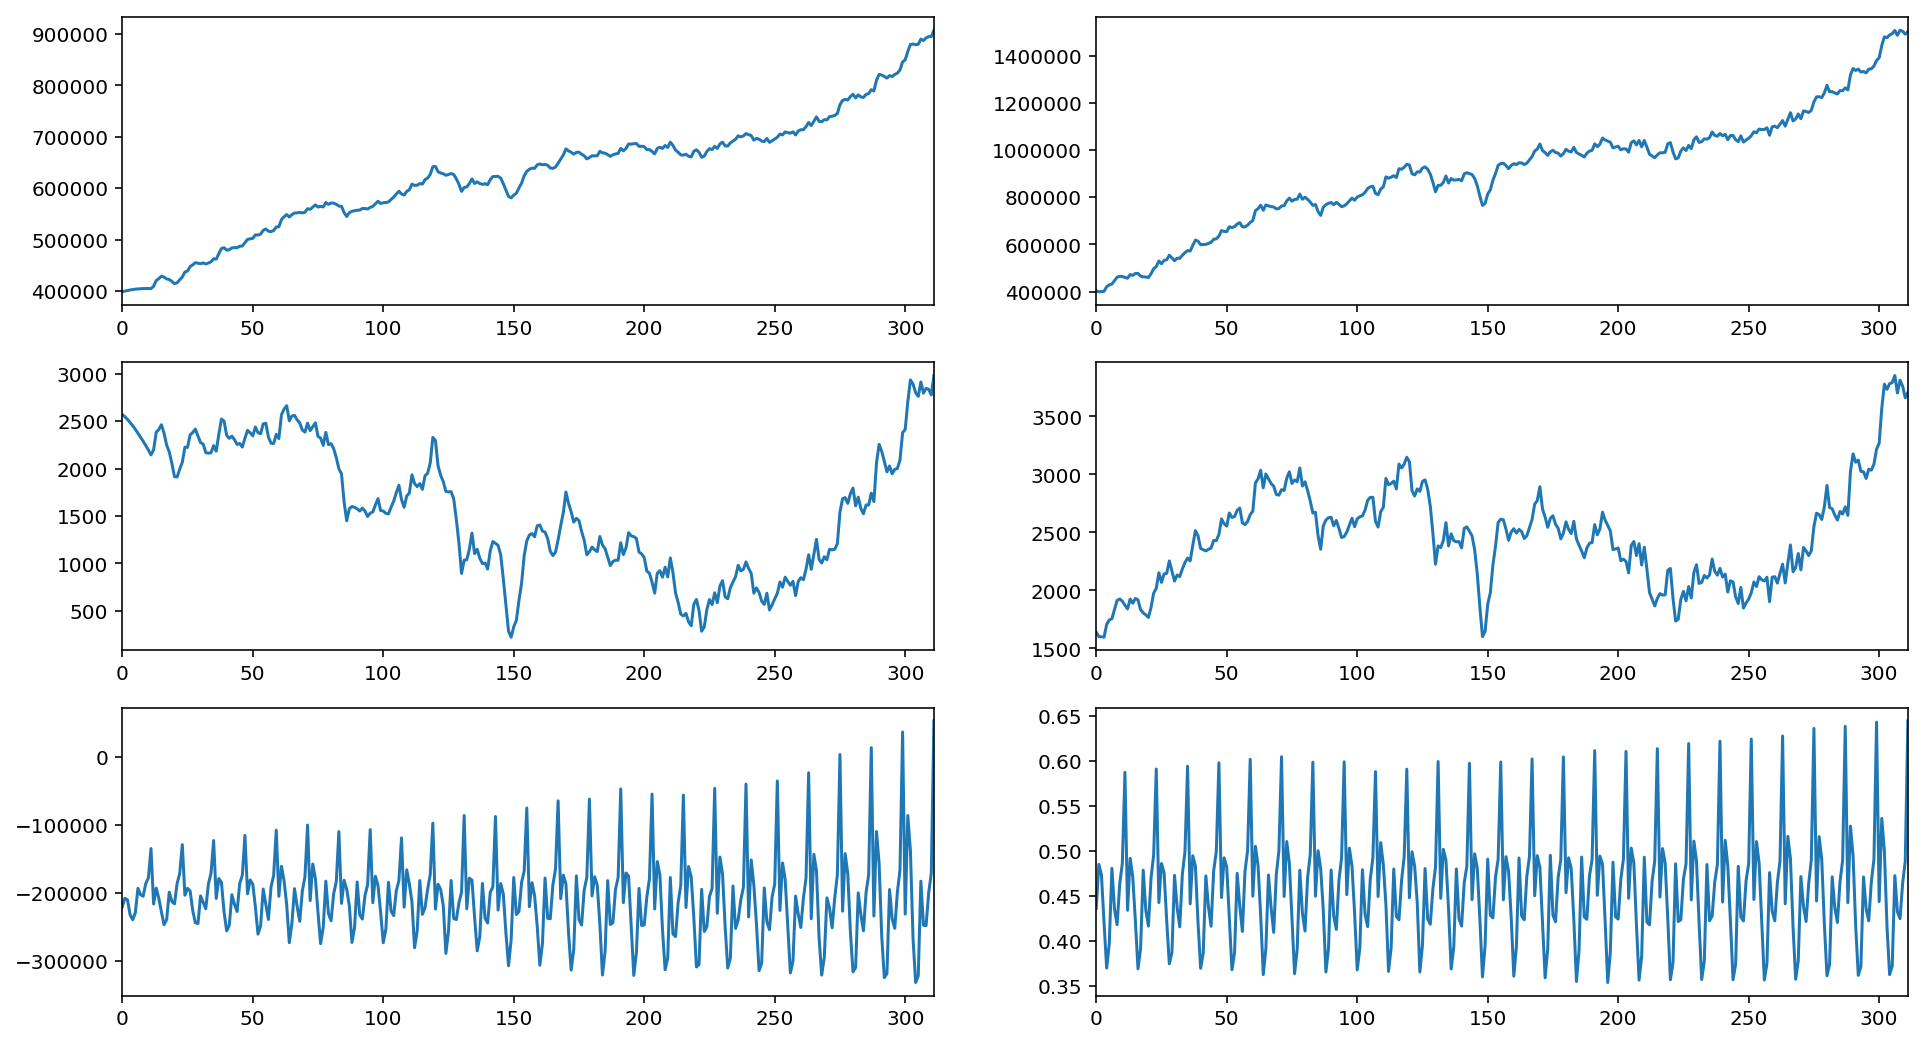

In [43]:
# Ploting the level, trend and season for fit1 and fit2
# define 2 states variable for conveinence
states_add = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season], 
                          columns = ['level','slope','seasonal'], 
                          index = y.index)
states_mul = pd.DataFrame(np.c_[fit2.level, fit2.slope, fit2.season], 
                          columns = ['level','slope','seasonal'], 
                          index = y.index)

# define subplots windows
fig, [[ax1, ax4],[ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize = (16,9))
states_add['level'].plot(ax = ax1)
states_add['slope'].plot(ax = ax2)
states_add['seasonal'].plot(ax = ax3)
states_mul['level'].plot(ax = ax4)
states_mul['slope'].plot(ax = ax5)
states_mul['seasonal'].plot(ax = ax6)
plt.show()

Then carefully exam the outcome by answering the following questions: 
1. What is the level range for both methods?
2. What is the slope range for both methods?
3. What is the seasonal range for both methods?
4. Let's put the residual aside and only consider the level, slope and seasonal. Based on these information, which decomposition method should you choose? Why?

**key words**  
1. define a new function  
`def function(variable):
    return results`
  
  
2. Holt-winters smoothing from statsmodels  
`model = ExponentialSmoothing(y, seasonal_period, trend = 'add', seasonal = 'add/mul')`  
`model.fit()`  
`model.fittedvalues`  
`model.forecast(fc)`  
